# Unassessed Exercise: CRF sequence tagging for Movie Queries

This exercises involves optimizing the performance of a **Conditional Random Field (CRF) sequence tagger** for movie trivia questions and answers data, which consist of instances of data of word sequences with the target classes/labels for each word in a **BIO (Beginning, Inside, Outside)** tagging format. 

This assignment involves reading in, pre-processing, training and developing your tagger on the training data from *trivia10k13train.bio.txt*, and finally testing your tagger on the data *trivia10k13test.bio.txt*, attempting to get the best performing tagger across the different labels in your development process. Parts of these steps have been done for you already. You are going to optimize the performance of the tagger by improving its feature extraction function on the word sequences, incorporating POS tagging first, then the final exercise is to optimize the performance by all legal means neccessary (except looking at the test data). Run and follow the code below and then attempt the questions.

In [1]:
# You may need to run this first- uncomment if so
!pip install python-crfsuite

In [2]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [3]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [4]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [5]:
# have a look at the first example
print(raw_training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [6]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

7816 instances
158823 words


In [7]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [8]:
training_data = [preProcess(example) for example in raw_training_data]

In [9]:
# check the effect of pre-processing
print(training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [10]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [11]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [12]:
# let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [13]:
# an example from the corpus
example = "steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies"
print_tags(example)

steve       B-Actor
mcqueen     I-Actor
provided    O
a           B-Plot
thrilling   I-Plot
motorcycle  I-Plot
chase       I-Plot
in          I-Plot
this        I-Plot
greatest    I-Plot
of          I-Plot
all         I-Plot
ww          I-Plot
2           I-Plot
prison      I-Plot
escape      I-Plot
movies      I-Plot


In [14]:
# a novel, unseen example we've just made up
print_tags("batman is the main character in batman begins")

batman      O
is          O
the         O
main        O
character   O
in          O
batman      B-Character_Name
begins      I-Character_Name


In [15]:
# another example
print_tags("the sound of music")

the         O
sound       O
of          O
music       O


In [16]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1953 instances
39035 words


In [17]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [18]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

/anaconda2/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                  precision    recall  f1-score   support

         B-Actor       0.85      0.88      0.87      1274
         B-Award       0.72      0.62      0.67        66
B-Character_Name       0.78      0.24      0.37       283
      B-Director       0.84      0.72      0.78       425
         B-Genre       0.83      0.76      0.80       789
       B-Opinion       0.49      0.30      0.37       195
        B-Origin       0.52      0.38      0.44       190
          B-Plot       0.49      0.47      0.48      1577
         B-Quote       0.75      0.26      0.38        47
  B-Relationship       0.80      0.53      0.64       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.94      0.97      0.96       661
         I-Actor       0.86      0.89      0.87      1553
         I-Award       0.74      0.69      0.72       147
I-Character_Name       0.82      0.30      0.43       227
      I-Director       0.89      0.74      0.81       411
         I-Ge

In [19]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

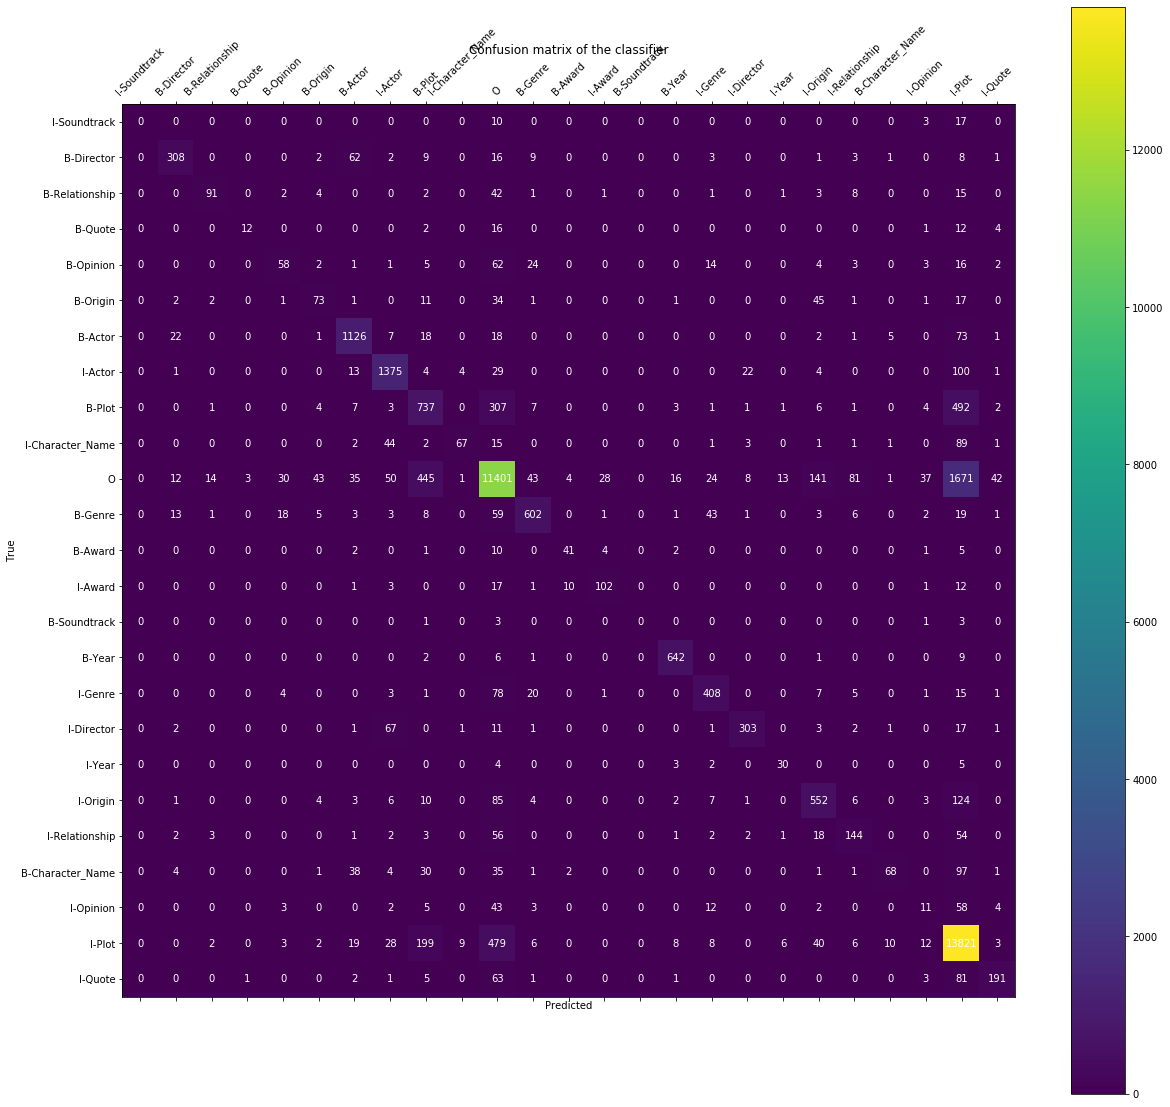

In [20]:
confusion_matrix_heatmap(y_test, preds)

In [21]:
# Let's see what the CRF learned by looking at the internal transition/feature weights....

In [21]:
def print_transition_weights(transitions):
    """Sort the transitions between states/labels from highest to
    lowest strengths and print out."""
    ranked_transitions = [x for x in sorted(transitions,
                                               key=lambda x:x[1], reverse=True)]
    for (label_from, label_to), weight in ranked_transitions:
        print("%0.6f %-8s -> %s" % (weight, label_from, label_to))

In [22]:
print_transition_weights(ct._tagger.info().transitions.items())

8.730936 B-Actor  -> I-Actor
8.345982 B-Plot   -> I-Plot
8.062881 B-Director -> I-Director
7.851024 B-Origin -> I-Origin
7.728286 I-Plot   -> I-Plot
7.557302 I-Quote  -> I-Quote
7.400516 B-Character_Name -> I-Character_Name
7.347592 I-Origin -> I-Origin
7.270472 B-Relationship -> I-Relationship
7.168646 B-Quote  -> I-Quote
7.019230 I-Relationship -> I-Relationship
6.874782 I-Soundtrack -> I-Soundtrack
6.792831 I-Opinion -> I-Opinion
6.739054 B-Genre  -> I-Genre
6.682199 B-Soundtrack -> I-Soundtrack
6.580473 B-Award  -> I-Award
6.441732 B-Opinion -> I-Opinion
6.428294 I-Award  -> I-Award
6.362482 I-Genre  -> I-Genre
6.348037 I-Actor  -> I-Actor
6.225893 I-Character_Name -> I-Character_Name
5.430455 I-Director -> I-Director
4.809019 I-Year   -> I-Year
4.082752 B-Year   -> I-Year
3.773733 B-Character_Name -> B-Plot
3.563915 O        -> O
3.562699 I-Character_Name -> B-Plot
3.277145 O        -> B-Plot
3.199695 B-Plot   -> B-Character_Name
3.091597 B-Opinion -> B-Genre
3.030532 O        -> 

In [23]:
def print_most_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)  # assume we want to print all of them
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=True) \
         if x[0][1] not in excluded_classes][:top_k]
    for (attr, label), weight in ranked_state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

In [24]:
print_most_predictive_state_features(ct._tagger.info().state_features.items())

5.191234 B-Year   HAS_NUM
4.378852 B-Genre  WORD_animated
4.376891 I-Year   WORD_s
3.280298 B-Genre  WORD_thriller
2.998992 B-Quote  WORD_i
2.986864 I-Genre  WORD_animated
2.968166 B-Genre  WORD_action
2.913375 B-Plot   WORD_a
2.910979 B-Opinion WORD_blockbuster
2.682290 B-Award  WORD_oscar
2.667863 B-Genre  WORD_animation
2.596255 B-Relationship SUF_uel
2.572959 B-Director WORD_disney
2.563763 B-Opinion WORD_masterpiece
2.552841 I-Genre  WORD_fiction
2.542230 B-Award  SUF_car
2.527780 B-Relationship WORD_remake
2.471652 B-Actor  WORD_cher
2.439679 B-Genre  WORD_horror
2.427487 I-Genre  WORD_white
2.413953 B-Relationship WORD_sequel
2.410295 I-Genre  WORD_thriller
2.378248 B-Genre  WORD_slasher
2.370675 B-Genre  WORD_comedy
2.337885 B-Origin WORD_adapted
2.304871 I-Actor  WORD_cage
2.276711 B-Genre  WORD_documentary
2.231418 B-Director SUF_xar
2.231418 B-Director WORD_pixar
2.227497 B-Genre  WORD_romance
2.184817 B-Genre  WORD_war
2.180846 B-Award  WORD_won
2.177721 B-Plot   WORD_an
2.

0.732453 I-Actor  WORD_bogart
0.732407 I-Actor  SUF_ds
0.732349 I-Director SUF_ord
0.731873 B-Genre  WORD_buddy
0.731641 I-Plot   WORD_fight
0.731600 I-Character_Name SUF_olm
0.731591 I-Character_Name WORD_creed
0.731529 I-Director WORD_fincher
0.731275 I-Actor  WORD_wilson
0.731227 I-Actor  WORD_fox
0.731168 I-Director SUF_ese
0.730964 B-Character_Name WORD_silent
0.730601 I-Director SUF_ell
0.730572 B-Character_Name SUF_z
0.730301 B-Soundtrack WORD_white
0.730113 I-Director WORD_woo
0.730002 B-Plot   WORD_shower
0.729811 B-Actor  WORD_ellen
0.729772 B-Opinion WORD_everyone
0.729611 B-Character_Name WORD_blu
0.729561 I-Actor  SUF_ne
0.729396 I-Actor  WORD_mcqueen
0.729160 B-Plot   WORD_feel
0.729139 I-Character_Name SUF_lk
0.728720 B-Actor  WORD_sir
0.728701 I-Plot   WORD_what
0.728420 I-Soundtrack SUF_ta
0.728419 B-Opinion SUF_h
0.728289 I-Origin WORD_juliet
0.728021 B-Director SUF_mar
0.727847 I-Actor  WORD_bates
0.727705 B-Director WORD_matt
0.727654 B-Opinion WORD_fun
0.727618 I-A

0.545111 B-Relationship WORD_long
0.544952 I-Character_Name SUF_ace
0.544912 B-Plot   WORD_nuclear
0.544838 I-Plot   WORD_elite
0.544810 I-Plot   WORD_african
0.544746 I-Plot   WORD_zombies
0.544545 B-Actor  SUF_uba
0.544426 I-Director SUF_nn
0.544409 I-Plot   WORD_art
0.544316 I-Actor  WORD_fraser
0.544172 I-Opinion SUF_ove
0.544137 I-Plot   SUF_ild
0.543979 B-Origin SUF_way
0.543552 I-Origin WORD_mitchell
0.543145 B-Plot   SUF_ty
0.543078 I-Plot   WORD_nanny
0.542967 I-Actor  WORD_hoskins
0.542860 I-Character_Name SUF_ist
0.542846 I-Plot   WORD_cameras
0.542801 I-Plot   WORD_forces
0.542546 I-Plot   WORD_supernatural
0.542203 I-Plot   SUF_uy
0.542194 I-Director SUF_lin
0.541935 I-Character_Name SUF_tto
0.541915 I-Origin WORD_comic
0.541850 B-Plot   WORD_coming
0.541555 I-Director SUF_yle
0.541368 B-Actor  WORD_emile
0.541367 B-Actor  WORD_milla
0.541343 I-Plot   SUF_ts
0.541029 B-Origin SUF_c
0.540965 I-Origin WORD_dc
0.540877 B-Plot   SUF_ant
0.540844 I-Director WORD_forman
0.540769

0.440264 B-Director WORD_eastwood
0.440168 B-Character_Name WORD_vader
0.440135 B-Opinion WORD_intelligent
0.440074 I-Actor  SUF_dul
0.440074 I-Actor  WORD_abdul
0.440003 I-Origin WORD_ripper
0.439996 B-Plot   WORD_relentless
0.439940 I-Origin WORD_columnist
0.439919 B-Character_Name WORD_bridget
0.439912 I-Plot   SUF_azy
0.439877 I-Plot   WORD_trip
0.439874 B-Genre  WORD_counterculture
0.439867 B-Genre  SUF_an
0.439834 I-Origin SUF_ert
0.439812 I-Plot   WORD_down
0.439780 I-Character_Name WORD_protectors
0.439752 B-Actor  SUF_reg
0.439752 B-Actor  WORD_greg
0.439727 B-Relationship WORD_sequels
0.439714 B-Award  WORD_earned
0.439616 B-Relationship WORD_instrumental
0.439591 I-Plot   WORD_imprisoned
0.439459 I-Character_Name WORD_teasdale
0.439450 I-Actor  SUF_vez
0.439431 B-Actor  SUF_ope
0.439322 I-Character_Name SUF_su
0.439322 I-Character_Name SUF_tsu
0.439322 I-Character_Name WORD_tetsu
0.439267 B-Origin WORD_battle
0.439252 I-Actor  WORD_cumberbatch
0.439243 I-Plot   WORD_learning

0.366117 B-Character_Name WORD_megatron
0.366085 B-Character_Name SUF_bs
0.366041 I-Actor  SUF_af
0.366033 B-Relationship SUF_984
0.366033 B-Relationship WORD_1984
0.366025 B-Plot   SUF_and
0.366022 I-Quote  SUF_ens
0.366022 B-Origin WORD_king
0.365986 I-Plot   WORD_rampaging
0.365960 B-Plot   WORD_examination
0.365881 I-Director SUF_ni
0.365864 B-Plot   WORD_weakling
0.365812 B-Actor  SUF_es
0.365700 B-Opinion SUF_ga
0.365661 I-Plot   WORD_kind
0.365598 B-Director SUF_nic
0.365581 B-Actor  WORD_b
0.365555 I-Quote  WORD_hell
0.365535 I-Actor  SUF_for
0.365535 I-Actor  WORD_balfor
0.365484 I-Relationship WORD_7
0.365474 I-Plot   WORD_britain
0.365301 I-Quote  WORD_refuse
0.365298 B-Soundtrack SUF_cal
0.365261 I-Origin WORD_cactus
0.365211 B-Character_Name SUF_ck
0.365125 B-Character_Name WORD_same
0.365073 B-Actor  SUF_yle
0.365023 I-Quote  SUF_ors
0.364944 B-Opinion WORD_famed
0.364940 I-Origin WORD_fim
0.364912 I-Character_Name WORD_hockley
0.364910 B-Plot   WORD_slashers
0.364905 I-A

0.298333 B-Relationship SUF_d
0.298306 I-Director WORD_wang
0.298302 I-Plot   WORD_safe
0.298270 I-Plot   WORD_journalist
0.298258 B-Director WORD_dennis
0.298257 I-Actor  WORD_molina
0.298230 I-Plot   WORD_roofer
0.298211 I-Opinion SUF_lso
0.298211 I-Opinion WORD_also
0.298188 I-Plot   WORD_explode
0.298134 I-Plot   WORD_birth
0.298112 I-Character_Name SUF_lop
0.298099 I-Plot   WORD_stopped
0.298062 I-Origin WORD_alice
0.298012 B-Character_Name SUF_yer
0.298011 B-Character_Name WORD_obi
0.297972 I-Plot   SUF_997
0.297972 I-Plot   WORD_1997
0.297876 I-Plot   SUF_rbs
0.297876 I-Plot   WORD_suburbs
0.297857 B-Plot   WORD_enchanted
0.297775 I-Plot   WORD_munny
0.297714 B-Plot   WORD_titans
0.297692 B-Plot   WORD_scientists
0.297623 I-Plot   WORD_smuggling
0.297619 I-Plot   SUF_nly
0.297590 I-Actor  WORD_bonacelli
0.297572 B-Character_Name SUF_go
0.297560 I-Character_Name WORD_miyaggi
0.297548 I-Actor  SUF_cus
0.297514 I-Director SUF_ez
0.297376 B-Opinion SUF_g
0.297352 I-Plot   WORD_has
0

0.222705 I-Actor  WORD_sorvino
0.222700 I-Plot   SUF_000
0.222695 B-Actor  SUF_by
0.222671 I-Plot   WORD_hills
0.222614 I-Actor  SUF_bin
0.222601 B-Soundtrack SUF_us
0.222545 I-Plot   WORD_jolly
0.222530 I-Plot   WORD_gift
0.222506 B-Plot   WORD_taking
0.222447 I-Award  WORD_in
0.222353 I-Plot   WORD_stockbroker
0.222346 I-Actor  WORD_reuten
0.222281 B-Relationship SUF_s
0.222240 I-Director SUF_tal
0.222239 B-Plot   SUF_co
0.222220 B-Quote  WORD_may
0.222150 B-Character_Name SUF_rgo
0.222145 B-Year   SUF_56
0.222145 B-Year   SUF_956
0.222145 B-Year   WORD_1956
0.222089 B-Plot   WORD_siberian
0.222064 I-Plot   WORD_pevensie
0.222032 I-Director WORD_beatty
0.221912 I-Director SUF_way
0.221828 I-Plot   WORD_use
0.221817 I-Plot   WORD_bah
0.221781 I-Plot   WORD_nephew
0.221684 B-Director WORD_warren
0.221672 B-Plot   WORD_artificial
0.221660 I-Plot   WORD_husbands
0.221659 I-Origin WORD_from
0.221653 I-Origin WORD_shirow
0.221651 I-Plot   SUF_vy
0.221617 B-Plot   WORD_zero
0.221574 I-Actor

0.149437 I-Director WORD_yakin
0.149411 I-Actor  WORD_provine
0.149359 I-Director SUF_as
0.149346 I-Plot   WORD_gentile
0.149335 B-Plot   SUF_kie
0.149277 B-Actor  WORD_orlando
0.149249 I-Actor  SUF_ul
0.149215 I-Origin WORD_capcom
0.149215 I-Actor  WORD_jen
0.149196 I-Plot   WORD_uprising
0.149189 I-Plot   WORD_looks
0.149124 I-Actor  WORD_plummer
0.149121 B-Actor  WORD_patricia
0.149105 I-Plot   WORD_hong
0.149105 I-Actor  WORD_elaine
0.149100 I-Plot   WORD_australia
0.149061 I-Actor  WORD_paquin
0.149048 I-Origin WORD_steinbeck
0.149046 B-Plot   WORD_alienated
0.149037 B-Relationship WORD_television
0.149020 I-Plot   WORD_big
0.148990 I-Actor  WORD_sienna
0.148971 I-Quote  WORD_just
0.148869 B-Origin SUF_zed
0.148863 I-Relationship WORD_lion
0.148808 I-Director WORD_play
0.148755 I-Plot   WORD_nosed
0.148751 I-Actor  SUF_uer
0.148683 I-Origin SUF_ath
0.148651 I-Actor  SUF_ino
0.148634 B-Plot   SUF_b
0.148606 I-Plot   WORD_linearly
0.148575 I-Actor  WORD_holder
0.148523 I-Actor  WORD

0.089786 I-Plot   WORD_nightclub
0.089781 B-Plot   WORD_mission
0.089745 B-Plot   SUF_zza
0.089745 B-Plot   WORD_pizza
0.089745 I-Plot   WORD_rampant
0.089739 B-Plot   WORD_blasts
0.089730 B-Character_Name SUF_sel
0.089663 I-Plot   WORD_manner
0.089576 I-Plot   WORD_struck
0.089572 I-Actor  WORD_russell
0.089526 B-Plot   SUF_ege
0.089526 I-Plot   WORD_sort
0.089486 I-Plot   WORD_addresses
0.089476 B-Actor  WORD_denzil
0.089454 I-Plot   WORD_manipulates
0.089427 B-Plot   WORD_spans
0.089424 I-Plot   WORD_rains
0.089409 I-Plot   WORD_field
0.089408 I-Plot   WORD_chronicling
0.089405 I-Plot   WORD_sweethearts
0.089399 I-Origin SUF_fin
0.089399 I-Origin WORD_giffin
0.089379 I-Plot   WORD_threatening
0.089376 I-Actor  WORD_cloris
0.089346 I-Plot   WORD_sleigh
0.089344 I-Plot   WORD_speck
0.089309 I-Plot   WORD_discovers
0.089274 B-Plot   WORD_time
0.089212 I-Character_Name SUF_ugh
0.089203 I-Actor  WORD_ladd
0.089183 B-Genre  SUF_ti
0.089103 I-Origin WORD_god
0.089096 I-Plot   WORD_defeated

0.031242 I-Plot   WORD_serve
0.031237 I-Plot   WORD_strives
0.031233 I-Actor  WORD_burlinson
0.031207 I-Plot   WORD_proposal
0.031157 I-Plot   WORD_embraces
0.031132 B-Character_Name SUF_ver
0.031132 I-Actor  SUF_oph
0.031132 I-Actor  WORD_christoph
0.031130 I-Plot   WORD_stapled
0.031128 B-Actor  SUF_ci
0.031112 I-Plot   WORD_preform
0.031108 I-Plot   WORD_reporter
0.031101 I-Plot   WORD_spreads
0.031097 I-Plot   WORD_attach
0.031076 I-Plot   WORD_draws
0.031070 I-Plot   WORD_nursing
0.031066 I-Plot   WORD_pertaining
0.031040 I-Plot   WORD_sudden
0.031023 I-Plot   WORD_inferior
0.031015 I-Plot   WORD_solving
0.031014 I-Plot   WORD_mushrooms
0.031007 I-Plot   WORD_tigger
0.030920 I-Plot   WORD_defies
0.030919 I-Origin SUF_rs
0.030889 I-Plot   WORD_teachers
0.030842 I-Plot   WORD_extraterrestrials
0.030832 I-Plot   WORD_interviews
0.030831 I-Plot   WORD_artifacts
0.030793 I-Plot   SUF_ok
0.030719 I-Plot   WORD_freight
0.030708 I-Plot   WORD_apaches
0.030706 B-Director SUF_ive
0.030694 I

0.005036 I-Plot   WORD_homestead
0.005021 I-Plot   WORD_galahad
0.004954 I-Plot   WORD_colossal
0.004950 I-Origin SUF_rke
0.004948 I-Plot   WORD_boost
0.004945 I-Plot   WORD_togeather
0.004937 I-Plot   WORD_harmless
0.004916 I-Plot   WORD_stops
0.004901 I-Plot   WORD_raucous
0.004898 I-Plot   WORD_propose
0.004872 I-Plot   WORD_continent
0.004870 I-Plot   WORD_disinherited
0.004838 I-Plot   WORD_valueless
0.004832 I-Plot   WORD_cultures
0.004830 I-Plot   WORD_corral
0.004825 I-Plot   WORD_cheated
0.004807 I-Plot   WORD_ravaged
0.004804 I-Plot   SUF_fes
0.004804 I-Plot   WORD_wifes
0.004803 I-Plot   SUF_erm
0.004802 I-Relationship WORD_popular
0.004802 I-Plot   WORD_evacuate
0.004800 I-Plot   WORD_costs
0.004778 I-Plot   WORD_transfers
0.004776 I-Plot   WORD_hid
0.004742 I-Plot   WORD_youngest
0.004741 I-Plot   WORD_pageant
0.004739 I-Plot   WORD_unbeknownst
0.004731 I-Plot   WORD_chemotherapy
0.004726 I-Plot   WORD_infiltrate
0.004718 I-Plot   WORD_removes
0.004702 I-Plot   WORD_despis

-0.083806 I-Plot   WORD_else
-0.083876 I-Plot   WORD_spending
-0.083891 I-Plot   WORD_start
-0.083950 I-Plot   SUF_fel
-0.083950 I-Plot   WORD_eiffel
-0.083967 I-Actor  SUF_kie
-0.083977 I-Origin SUF_ga
-0.083987 I-Plot   WORD_repeating
-0.084310 I-Relationship SUF_ch
-0.084392 I-Plot   WORD_roulette
-0.084421 I-Character_Name SUF_ma
-0.084443 B-Plot   SUF_ene
-0.084836 I-Character_Name SUF_ta
-0.084838 I-Genre  WORD_based
-0.084865 I-Origin SUF_ore
-0.085070 B-Actor  SUF_een
-0.085077 I-Plot   WORD_entire
-0.085124 I-Plot   SUF_nco
-0.085124 I-Plot   WORD_franco
-0.085171 I-Plot   WORD_misadventures
-0.085224 B-Genre  SUF_ll
-0.085307 B-Quote  SUF_n
-0.085421 I-Plot   SUF_ict
-0.085434 I-Plot   WORD_sequence
-0.085446 B-Plot   SUF_os
-0.085482 I-Plot   WORD_sends
-0.085496 I-Plot   SUF_ou
-0.085697 I-Plot   WORD_nun
-0.085798 B-Genre  SUF_us
-0.085813 I-Plot   WORD_concerned
-0.085826 I-Character_Name SUF_ody
-0.085889 I-Origin SUF_ull
-0.085939 I-Plot   SUF_em
-0.085978 I-Relationshi

-0.370145 I-Plot   WORD_chief
-0.370247 I-Plot   WORD_great
-0.370269 I-Plot   WORD_buttercup
-0.370428 B-Actor  SUF_le
-0.371362 I-Actor  WORD_sparrow
-0.371686 I-Quote  SUF_it
-0.371836 B-Actor  SUF_lla
-0.372476 I-Plot   SUF_nry
-0.372476 I-Plot   WORD_henry
-0.372575 I-Plot   WORD_juliet
-0.372608 I-Plot   WORD_tap
-0.372627 I-Actor  SUF_ol
-0.373004 I-Plot   SUF_urn
-0.374760 B-Plot   SUF_se
-0.375539 I-Actor  SUF_ir
-0.375684 I-Plot   WORD_sad
-0.375767 I-Plot   WORD_100
-0.375798 I-Plot   SUF_sey
-0.375825 I-Plot   SUF_lis
-0.375852 I-Plot   WORD_prepare
-0.375997 I-Plot   WORD_float
-0.376156 I-Plot   WORD_drama
-0.376160 I-Plot   WORD_football
-0.376435 I-Relationship SUF_ost
-0.376487 I-Origin SUF_uy
-0.376571 I-Plot   WORD_lovable
-0.376634 I-Plot   WORD_solves
-0.376732 I-Plot   WORD_charming
-0.377557 I-Origin SUF_tor
-0.378524 I-Plot   SUF_af
-0.379086 I-Plot   WORD_scheming
-0.379254 I-Plot   WORD_knife
-0.380409 I-Plot   WORD_eternal
-0.380879 I-Actor  SUF_sky
-0.381313

# 1. Split the training data into 80% training, 20% development set
Split the training data (`training_data`) into two lists: one split of the first 80% of the instances of `training_data`, which you will use for training your CRF, and the remaining 20% for testing. Once you've done this re-run the above code such that the tagger is trained on the 80% split and tested on the 20% split, and you obtain the classification report output and confusion heatmap output for the results of testing. Do not use the test data as it is above for testing/viewing results for now. Record the results by saving the classification report output as a string somewhere in the notebook for future reference as you go through.


# 2. Error analysis 1: False positives

Performing error analyses is a key part of improving your NLP applications. For the 5 classes which have the lowest precision, according to the results table from your 20% development data, print out all the sentences where there is a false positive for that class (i.e. the label is predicted in the predicted label for a given word by the tagger, but this is not present in the corresponding ground truth label for that word). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


# 3. Error analysis 2: False negatives

For the 5 classes which have the lowest recall, according to the results table from your 20% development data,, print out all the sentences where there is a false negative for that label (i.e. the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


# 4. Incorporating POS tags as features
Use the CRF part-of-speech (POS) tagger as shown below to add POS tags to the words in the training data. Do this by altering the `preProcess` function above. Note the CRF tagger only takes strings as input so you will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and you will also have to then split on this special symbol in the feature extraction function `get_features` to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by `feature_list.append("WORD_" + token)`. Re-run the training and testing code on your 80%/20% training/dev split from question 1 and record the results from the classification report as text in this file for comparison of the accuracy metrics against not using POS tags- try to see any improvemements across the classes.

In [25]:
# a postagger for use in exercises
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
# example use:
words = ["john", "likes", "mary", "and", "bill"]
print(posttagger.tag(words))

[('john', 'NNP'), ('likes', 'VBZ'), ('mary', 'JJ'), ('and', 'CC'), ('bill', 'NN')]


# 5. Feature experimentation and other optimization for optimal macro average.
Experiment with different features by further adjusting the `get_features` function, and modifying it to get the best results in terms of `macro average f-score` (i.e. average f-score across all classes) on your 20% development data. Iteratively try different functions, briefly describe the method and record the results in the classification report format.

Feature tips: You could try more suffixes/prefixes of the current word than those currently extracted, you could use windows of the next and previous tokens (of different sizes, e.g. the previous/next N words/tags). As you try different feature functions, use the techniques you used in Q2 and Q3 to see the kind of errors you are getting for lower performing classes, in addition to the confusion matrix over classes.

Model tips: After your feature engineering, for even better performance you could try optimizing the hyperparameters by adjusting the `training_opt` dictionary values, experimenting with changing the minimum document frequency, c1 and c2 regularization parameters for https://www.nltk.org/api/nltk.tag.crf.html#nltk.tag.crf.CRFTagger.__init__ e.g. changing the initialization to make the minimum feature frequency 2 (rather than the default 1) would be:

`ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":2})`

Leave the `get_features` functions in the state you used to get the highest `macro average f-score` on your 20% development set, then re-train the model on ALL the training data and print the classification report for the original test data (i.e. from the test file `trivia10k13train.bio.txt`) as your final piece of code.

In [26]:
# Final results on original test data, using all training data, with best settings from dev set:

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")


# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

print("testing tagger on test data...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

1953 instances
39035 words
training tagger...
done
1953 instances
39035 words
testing tagger on test data...
done


In [27]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

/anaconda2/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                  precision    recall  f1-score   support

         B-Actor       0.85      0.88      0.87      1274
         B-Award       0.72      0.62      0.67        66
B-Character_Name       0.78      0.24      0.37       283
      B-Director       0.84      0.72      0.78       425
         B-Genre       0.83      0.76      0.80       789
       B-Opinion       0.49      0.30      0.37       195
        B-Origin       0.52      0.38      0.44       190
          B-Plot       0.49      0.47      0.48      1577
         B-Quote       0.75      0.26      0.38        47
  B-Relationship       0.80      0.53      0.64       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.94      0.97      0.96       661
         I-Actor       0.86      0.89      0.87      1553
         I-Award       0.74      0.69      0.72       147
I-Character_Name       0.82      0.30      0.43       227
      I-Director       0.89      0.74      0.81       411
         I-Ge